In [95]:
import json
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [97]:
import numpy as np 
import pandas as pd
from glob import glob
import os
import pickle
import datasets
from datasets import load_dataset

In [ ]:
ds = load_dataset("/data/healthy-ml/scratch/qixuanj/generative_validation/sd_chestxray_loading.py")

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
Generating train split: 11414 examples [48:16,  3.73 examples/s]

In [100]:
# Functional 
ds = load_dataset("/data/healthy-ml/scratch/qixuanj/generative_validation/sd_chestxray_loading_base.py", "chexpert_base")

Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 32 examples [00:02, 12.03 examples/s]


KeyboardInterrupt: 

## Make text prompt balanced match classifier training

In [32]:
datasets = ["mimic", "chexpert", "padchest", "nih"]

In [4]:
# base: 10000 
with open("/data/healthy-ml/scratch/qixuanj/generative_validation/cxr_prompt_files.pkl", 'rb') as f:
    data = pickle.load(f)

In [6]:
with open("split_datasets_balanced.pkl", "rb") as f: 
    split_datasets_balanced = pickle.load(f)

In [34]:
match_prompt = {}
for d in datasets: 
    match_prompt[d] = {}

In [46]:
ids = split_datasets_balanced['mimic']['train'].csv.apply(lambda row: f'p{str(row["subject_id"])[:2]}/p{row["subject_id"]}/s{row["study_id"]}/{row["dicom_id"]}.jpg', axis=1)
match_prompt['mimic']['train'] = data['mimic'][data['mimic']['file_suffix'].isin(ids)]
match_prompt['mimic']['train'] = match_prompt['mimic']['train'].drop(columns=["split"]).drop_duplicates()
ids = split_datasets_balanced['mimic']['test'].csv.apply(lambda row: f'p{str(row["subject_id"])[:2]}/p{row["subject_id"]}/s{row["study_id"]}/{row["dicom_id"]}.jpg', axis=1)
match_prompt['mimic']['test'] = data['mimic'][data['mimic']['file_suffix'].isin(ids)]
match_prompt['mimic']['test'] = match_prompt['mimic']['test'].drop(columns=["split"]).drop_duplicates()

In [56]:
ids  = split_datasets_balanced['chexpert']['train'].csv['Path']
match_prompt['chexpert']['train'] = data['chexpert'][data['chexpert']['file_suffix'].isin(ids)]
match_prompt['chexpert']['train'] = match_prompt['chexpert']['train'].drop(columns=["split"]).drop_duplicates()
ids  = split_datasets_balanced['chexpert']['test'].csv['Path']
match_prompt['chexpert']['test'] = data['chexpert'][data['chexpert']['file_suffix'].isin(ids)]
match_prompt['chexpert']['test'] = match_prompt['chexpert']['test'].drop(columns=["split"]).drop_duplicates()

In [60]:
ids  = split_datasets_balanced['nih']['train'].csv['Image Index']
match_prompt['nih']['train'] = data['nih'][data['nih']['file_suffix'].isin(ids)]
match_prompt['nih']['train'] = match_prompt['nih']['train'].drop(columns=["split"]).drop_duplicates()
ids  = split_datasets_balanced['nih']['test'].csv['Image Index']
match_prompt['nih']['test'] = data['nih'][data['nih']['file_suffix'].isin(ids)]
match_prompt['nih']['test'] = match_prompt['nih']['test'].drop(columns=["split"]).drop_duplicates()

In [62]:
ids  = split_datasets_balanced['padchest']['train'].csv['ImageID']
match_prompt['padchest']['train'] = data['padchest'][data['padchest']['file_suffix'].isin(ids)]
match_prompt['padchest']['train'] = match_prompt['padchest']['train'].drop(columns=["split"]).drop_duplicates()
ids  = split_datasets_balanced['padchest']['test'].csv['ImageID']
match_prompt['padchest']['test'] = data['padchest'][data['padchest']['file_suffix'].isin(ids)]
match_prompt['padchest']['test'] = match_prompt['padchest']['test'].drop(columns=["split"]).drop_duplicates()

In [63]:
for d in datasets:
    print(d)
    print(len(match_prompt[d]['train']))
    print(len(match_prompt[d]['test']))

mimic
9561
9434
chexpert
10000
10000
padchest
10000
10000
nih
10000
10000


In [94]:
match_prompt['mimic']['train']

,view,patientid,labels,file_suffix,age_years,sex_female,sex_male,dataset_name
0,PA,10000032,No Finding,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,52,True,False,mimic
1,PA,10000032,No Finding,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,52,True,False,mimic
2,AP,10000032,No Finding,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,52,True,False,mimic
3,AP,10000032,No Finding,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,52,True,False,mimic
4,AP,10000032,No Finding,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,52,True,False,mimic
...,...,...,...,...,...,...,...,...
12981,PA,10476869,,p10/p10476869/s57207510/bef4e780-d62c3839-c827...,57,False,True,mimic
12982,PA,10476869,,p10/p10476869/s57266820/29b3f97c-059b2726-fac1...,57,False,True,mimic
12983,PA,10476869,,p10/p10476869/s57266820/6c26230f-0297e51d-5092...,57,False,True,mimic
12984,PA,10476869,No Finding,p10/p10476869/s57292220/b7c48559-6eb5f6fe-eea1...,57,False,True,mimic


In [64]:
with open("/data/healthy-ml/scratch/qixuanj/generative_validation/cxr_prompt_files_base10000.pkl", 'wb') as f:
    pickle.dump(match_prompt, f)

In [65]:
# transfer: 
with open("transfer_dataset_seed0.pkl", "rb") as f: 
    transfer_dataset = pickle.load(f)

In [72]:
train_nums = [10, 50, 100, 250, 500, 1000]
ds_configs = ['match_ds', 'balanced_ds']

In [91]:
with open("transfer_dataset_seed4.pkl", "rb") as f: 
    transfer_dataset = pickle.load(f)
    
transfer_prompt = {}
for d in datasets: 
    transfer_prompt[d] = {}
    for train_num in train_nums: 
        transfer_prompt[d][train_num] = {}
        for config in ds_configs: 
            if d == "mimic":
                ids = transfer_dataset[d][train_num][config].csv.apply(lambda row: f'p{str(row["subject_id"])[:2]}/p{row["subject_id"]}/s{row["study_id"]}/{row["dicom_id"]}.jpg', axis=1)
            elif d == "chexpert": 
                ids = transfer_dataset[d][train_num][config].csv['Path']
            elif d == "padchest": 
                ids = transfer_dataset[d][train_num][config].csv['ImageID']
            elif d == "nih": 
                ids = transfer_dataset[d][train_num][config].csv['Image Index']
            transfer_prompt[d][train_num][config] = data[d][data[d]['file_suffix'].isin(ids)]
            transfer_prompt[d][train_num][config] = transfer_prompt[d][train_num][config].drop(columns=["split"]).drop_duplicates()

In [92]:
with open("/data/healthy-ml/scratch/qixuanj/generative_validation/cxr_prompt_files_transfer_seed4.pkl", 'wb') as f:
    pickle.dump(transfer_prompt, f)

## Make text prompt balanced version

In [49]:
datasets = ['mimic', 'padchest', 'chexpert', 'nih']

In [4]:
with open("cxr_prompt_files.pkl", "rb") as f: 
    prompt_files_df = pickle.load(f)

In [56]:
prompt_files_df_balanced = {}
max_count = 1000 
for d in datasets: 
    # Only balance test split 
    tmp = prompt_files_df[d][prompt_files_df[d]['split'] == 'train']
    tmp_not_train = prompt_files_df[d][prompt_files_df[d]['split'] != 'train']

    tmp_value_counts = tmp['labels'].value_counts()
    tmp_value_counts = tmp_value_counts[tmp_value_counts > max_count]
    print("Num above max count: {}".format(len(tmp_value_counts)))
    print(f"Old train dataset {d} size: {len(tmp)}")
    tmp_sampled = tmp[tmp['labels'].isin(tmp_value_counts.index)]
    tmp_sampled = tmp_sampled.groupby("labels").sample(max_count)
    tmp_remain = tmp[~tmp['labels'].isin(tmp_value_counts.index)]
    tmp_new = pd.concat([tmp_sampled, tmp_remain], axis=0)
    print(f"New train dataset {d} size: {len(tmp_new)}")
    tmp_new = pd.concat([tmp_new, tmp_not_train], axis = 0)
    prompt_files_df_balanced[d] = tmp_new 

Num above max count: 15
Old train dataset mimic size: 161198
New train dataset mimic size: 26531
Num above max count: 6
Old train dataset padchest size: 66330
New train dataset padchest size: 8348
Num above max count: 15
Old train dataset chexpert size: 134585
New train dataset chexpert size: 22388
Num above max count: 8
Old train dataset nih size: 78631
New train dataset nih size: 12650


In [58]:
with open("cxr_prompt_files_balanced1000.pkl", "wb") as f: 
    pickle.dump(prompt_files_df_balanced, f)

# Make the prompt json files

In [ ]:
'''
for each dataset:
file_suffix: append to img_dir and can load the images 
dataset_name: domain name used in identification ["mimic", "chexpert", "padchest", "nih"] 
labels: out of 8 pathologies: ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
                               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"]
split: train, val, test split matching torchxrayvision reproduced table 2 previously (seed 0)
view: AP or PA
'''

In [15]:
import torchxrayvision as xrv
import skimage, torch, torchvision

In [16]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(512)])
d_chex = xrv.datasets.CheX_Dataset(imgpath="/data/healthy-ml/gobi1/data/CheXpert-v1.0-small",
                                   csvpath="/data/healthy-ml/gobi1/data/CheXpert-v1.0-small/train.csv",
                                   transform=transform, views=["PA", "AP"], unique_patients=False)
d_pc = xrv.datasets.PC_Dataset(imgpath="/data/healthy-ml/gobi1/data/PadChest/images-224", 
                               transform=transform, views=["PA", "AP"], unique_patients=False)
d_mimic = xrv.datasets.MIMIC_Dataset(imgpath="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                                    csvpath="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-chexpert.csv.gz", 
                                    metacsvpath="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-metadata.csv.gz", 
                                    transform=transform, views=["AP", "PA"], unique_patients=False)
d_nih = xrv.datasets.NIH_Dataset(imgpath="/data/healthy-ml/gobi1/data/ChestXray8/images",
                                 transform=transform, views=["PA","AP"], unique_patients=False)

Setting XRayResizer engine to cv2 could increase performance.


In [17]:
# The 8 target pathologies to standardize to 
pathologies = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"]
# Standardization for NIH 
new_labels = pd.DataFrame(d_nih.labels, columns = d_nih.pathologies)
# Combine "Mass" and "Nodule" as "Lesion" class
new_labels['Lesion'] = new_labels['Mass'] + new_labels['Nodule']
new_labels['Lesion'][new_labels['Lesion'] > 1] = 1
# If all negative findings for original labels, set as no finding  
new_labels['No Finding'] = new_labels.eq(0).all(axis=1).astype(float)
d_nih.pathologies = new_labels.columns.values
d_nih.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_nih)

# Standardization for PadChest 
new_labels = pd.DataFrame(d_pc.labels, columns = d_pc.pathologies) 
# Combine "Mass" and "Nodule" as "Lesion" class
new_labels['Lesion'] = new_labels['Mass'] + new_labels['Nodule']
new_labels['Lesion'][new_labels['Lesion'] > 1] = 1
no_findings_list = list(new_labels.columns)
no_findings_list.remove("Support Devices") 
no_findings_list.remove("Tube") 
print(no_findings_list)

# If all negative findings for selected labels, set as no finding  
new_labels['No Finding'] = new_labels[no_findings_list].eq(0).all(axis=1).astype(float)
d_pc.pathologies = new_labels.columns.values
d_pc.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_pc)

# Standardization for CheXpert 
d_chex.pathologies = ["Lesion" if x == "Lung Lesion" else x for x in d_chex.pathologies]
new_labels = pd.DataFrame(d_chex.labels, columns = d_chex.pathologies) 
no_findings_list = list(new_labels.columns)
no_findings_list.remove("Support Devices") 
# If all negative findings for selected labels, set as no finding  
new_labels['No Finding'] = new_labels[no_findings_list].eq(0).all(axis=1).astype(float)
d_chex.pathologies = new_labels.columns.values
d_chex.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_chex)

# Standardization for MIMIC-CXR 
d_mimic.pathologies = ["Lesion" if x == "Lung Lesion" else x for x in d_mimic.pathologies]
new_labels = pd.DataFrame(d_mimic.labels, columns = d_mimic.pathologies) 
no_findings_list = list(new_labels.columns)
no_findings_list.remove("Support Devices") 
print(no_findings_list)
# If all negative findings for selected labels, set as no finding  
new_labels['No Finding'] = new_labels[no_findings_list].eq(0).all(axis=1).astype(float)
d_mimic.pathologies = new_labels.columns.values
d_mimic.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_mimic)

{'Emphysema', 'Hernia', 'Pleural_Thickening', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Effusion'} will be dropped
['Air Trapping', 'Aortic Atheromatosis', 'Aortic Elongation', 'Atelectasis', 'Bronchiectasis', 'Cardiomegaly', 'Consolidation', 'Costophrenic Angle Blunting', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Flattened Diaphragm', 'Fracture', 'Granuloma', 'Hemidiaphragm Elevation', 'Hernia', 'Hilar Enlargement', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Scoliosis', 'Tuberculosis', 'Lesion']
{'Emphysema', 'Hernia', 'Pleural_Thickening', 'Scoliosis', 'Fibrosis', 'Infiltration', 'Granuloma', 'Support Devices', 'Fracture', 'Air Trapping', 'Bronchiectasis', 'Aortic Elongation', 'Flattened Diaphragm', 'Costophrenic Angle Blunting', 'Hilar Enlargement', 'Tube', 'Mass', 'Tuberculosis', 'Nodule', 'Effusion', 'Hemidiaphragm Elevation', 'Aortic Atheromatosis'} will be dropped
{'Enlarged Cardiomediastinum', 'Pleural Other', 'Lung Opacity',

In [18]:
from sklearn.model_selection import GroupShuffleSplit
# For reproducibility 
seed = 0 

original_datasets = {"mimic": d_mimic, 
                     "chexpert": d_chex, 
                     "nih": d_nih, 
                     "padchest": d_pc} 
split_datasets = {}
gss = GroupShuffleSplit(train_size=0.8,test_size=0.2, random_state=seed)
gss_val = GroupShuffleSplit(train_size=0.875,test_size=0.125, random_state=seed)

for name, dataset in original_datasets.items(): 
    train_inds, test_inds = next(gss.split(X=range(len(dataset)), groups=dataset.csv.patientid))
    train_inds, val_inds = next(gss_val.split(X=range(len(train_inds)), groups=train_inds))

    split_datasets[name] = {}
    split_datasets[name]["train"] = xrv.datasets.SubsetDataset(dataset, train_inds)
    split_datasets[name]["val"] = xrv.datasets.SubsetDataset(dataset, val_inds)
    split_datasets[name]["test"] = xrv.datasets.SubsetDataset(dataset, test_inds)

In [22]:
'''
all except for mimic has gender and age 
'''
for name, d in original_datasets.items(): 
    print(name)
    display(d.csv.iloc[0])
    print(d.csv.columns)

mimic


subject_id                                                                        10000032
study_id                                                                          50414267
Atelectasis                                                                            0.0
Cardiomegaly                                                                           0.0
Consolidation                                                                          0.0
Edema                                                                                  0.0
Enlarged Cardiomediastinum                                                             0.0
Fracture                                                                               0.0
Lung Lesion                                                                            0.0
Lung Opacity                                                                           0.0
No Finding                                                                             1.0

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'PerformedProcedureStepDescription', 'ViewPosition', 'Rows',
       'Columns', 'StudyDate', 'StudyTime',
       'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'view', 'offset_day_int',
       'patientid'],
      dtype='object')
chexpert


Path                          CheXpert-v1.0-small/train/patient00001/study1/...
Sex                                                                      Female
Age                                                                        68.0
Frontal/Lateral                                                         Frontal
AP/PA                                                                        AP
No Finding                                                                  1.0
Enlarged Cardiomediastinum                                                  0.0
Cardiomegaly                                                                0.0
Lung Opacity                                                                0.0
Lung Lesion                                                                 0.0
Edema                                                                       0.0
Consolidation                                                               0.0
Pneumonia                               

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'view', 'patientid', 'age_years', 'sex_male',
       'sex_female'],
      dtype='object')
nih


index                                         0
Image Index                    00000001_000.png
Finding Labels                     Cardiomegaly
Follow-up #                                   0
Patient ID                                    1
Patient Age                                  57
Patient Gender                                M
View Position                                PA
OriginalImage[Width                        2682
Height]                                    2749
OriginalImagePixelSpacing[x               0.143
y]                                        0.143
view                                         PA
has_masks                                 False
patientid                                     1
age_years                                  57.0
sex_male                                   True
sex_female                                False
Name: 0, dtype: object

Index(['index', 'Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'view', 'has_masks',
       'patientid', 'age_years', 'sex_male', 'sex_female'],
      dtype='object')
padchest


Unnamed: 0                                                                         0
ImageID                            20536686640136348236148679891455886468_k6ga29.png
ImageDir                                                                           0
StudyDate_DICOM                                                             20140915
StudyID                                       20536686640136348236148679891455886468
PatientID                                       839860488694292331637988235681460987
PatientBirth                                                                  1930.0
PatientSex_DICOM                                                                   F
ViewPosition_DICOM                                                   POSTEROANTERIOR
Projection                                                                        PA
MethodProjection                                       Manual review of DICOM fields
Pediatric                                                        

Index(['Unnamed: 0', 'ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID',
       'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM',
       'Projection', 'MethodProjection', 'Pediatric', 'Modality_DICOM',
       'Manufacturer_DICOM', 'PhotometricInterpretation_DICOM',
       'PixelRepresentation_DICOM', 'PixelAspectRatio_DICOM',
       'SpatialResolution_DICOM', 'BitsStored_DICOM', 'WindowCenter_DICOM',
       'WindowWidth_DICOM', 'Rows_DICOM', 'Columns_DICOM',
       'XRayTubeCurrent_DICOM', 'Exposure_DICOM', 'ExposureInuAs_DICOM',
       'ExposureTime', 'RelativeXRayExposure_DICOM', 'ReportID', 'Report',
       'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS',
       'view', 'offset_day_int', 'patientid', 'age_years', 'sex_male',
       'sex_female'],
      dtype='object')


In [95]:
prompt_files_df =  {
    "mimic": None, 
    "padchest": None, 
    "chexpert": None, 
    "nih": None, 
}

In [87]:
mimic_demo = pd.read_csv("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/patients.csv.gz")

In [88]:
mimic_demo

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299772,19999828,F,46,2147,2017 - 2019,NaN
299773,19999829,F,28,2186,2008 - 2010,NaN
299774,19999840,M,58,2164,2008 - 2010,2164-09-17
299775,19999914,F,49,2158,2017 - 2019,NaN


In [135]:
for name, split_dataset in split_datasets.items(): 
    if name == "mimic": 
        df_tmp = pd.DataFrame()
        for s in ["train", "val", "test"]: 
            tmp = split_dataset[s].csv[['view', 'subject_id', 'study_id', 'dicom_id', 'patientid']]
            tmp['split'] = s 
            tmp_label = pd.DataFrame(split_dataset[s].labels, columns = split_dataset[s].pathologies)
            tmp_label = tmp_label.fillna(0).astype(int)
            tmp['labels'] = tmp_label.dot(tmp_label.columns + ', ').str.rstrip(', ')
            df_tmp = pd.concat([df_tmp, tmp], ignore_index=True)
        df_tmp['file_suffix'] = df_tmp.apply(lambda row: f"p{str(row['subject_id'])[:2]}/p{row['subject_id']}/s{row['study_id']}/{row['dicom_id']}.jpg", axis=1)
        df_tmp = pd.merge(df_tmp, mimic_demo[['subject_id', 'anchor_age', 'gender']], left_on='subject_id', right_on='subject_id')
        df_tmp = pd.concat([df_tmp, pd.get_dummies(df_tmp[['gender']])], axis = 1)
        df_tmp = df_tmp.rename(columns = {'anchor_age': 'age_years', 'gender_F': 'sex_female', 'gender_M': 'sex_male'})
        df_tmp['dataset_name'] = name 
        df_tmp = df_tmp.drop(columns = ['subject_id', 'study_id', 'dicom_id', 'gender'])
        prompt_files_df[name] = df_tmp 
    elif name == "chexpert": 
        df_tmp = pd.DataFrame()
        for s in ["train", "val", "test"]: 
            tmp = split_dataset[s].csv[['Path', 'view', 'patientid', 'age_years', 'sex_male', 'sex_female']]
            tmp['split'] = s
            tmp_label = pd.DataFrame(split_dataset[s].labels, columns = split_dataset[s].pathologies)
            tmp_label = tmp_label.fillna(0).astype(int)
            tmp['labels'] = tmp_label.dot(tmp_label.columns + ', ').str.rstrip(', ')
            df_tmp = pd.concat([df_tmp, tmp], ignore_index=True)
        df_tmp['dataset_name'] = name 
        df_tmp = df_tmp.rename(columns = {'Path': 'file_suffix'}) 
        prompt_files_df[name] = df_tmp 
    elif name == "nih": 
        df_tmp = pd.DataFrame()
        for s in ["train", "val", "test"]: 
            tmp = split_dataset[s].csv[['Image Index', 'view', 'patientid', 'age_years', 'sex_male', 'sex_female']]
            tmp['split'] = s
            tmp_label = pd.DataFrame(split_dataset[s].labels, columns = split_dataset[s].pathologies)
            tmp_label = tmp_label.fillna(0).astype(int)
            tmp['labels'] = tmp_label.dot(tmp_label.columns + ', ').str.rstrip(', ')
            df_tmp = pd.concat([df_tmp, tmp], ignore_index=True)
        df_tmp['dataset_name'] = name 
        df_tmp = df_tmp.rename(columns = {'Image Index': 'file_suffix'})
        prompt_files_df[name] = df_tmp
    elif name == "padchest": 
        df_tmp = pd.DataFrame()
        for s in ["train", "val", "test"]: 
            tmp = split_dataset[s].csv[['ImageID', 'view', 'patientid', 'age_years', 'sex_male', 'sex_female']]
            tmp['split'] = s
            tmp_label = pd.DataFrame(split_dataset[s].labels, columns = split_dataset[s].pathologies)
            tmp_label = tmp_label.fillna(0).astype(int)
            tmp['labels'] = tmp_label.dot(tmp_label.columns + ', ').str.rstrip(', ')
            df_tmp = pd.concat([df_tmp, tmp], ignore_index=True)
        df_tmp['dataset_name'] = name 
        df_tmp = df_tmp.rename(columns = {'ImageID': 'file_suffix'})
        prompt_files_df[name] = df_tmp

In [136]:
prompt_files_df['mimic']

,view,patientid,split,labels,file_suffix,age_years,sex_female,sex_male,dataset_name
0,PA,10000032,train,No Finding,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,52,True,False,mimic
1,PA,10000032,train,No Finding,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,52,True,False,mimic
2,AP,10000032,train,No Finding,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,52,True,False,mimic
3,AP,10000032,train,No Finding,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,52,True,False,mimic
4,AP,10000032,train,No Finding,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,52,True,False,mimic
...,...,...,...,...,...,...,...,...,...
229933,AP,19998198,test,No Finding,p19/p19998198/s52656971/c50e0bc8-e572a388-f79e...,24,True,False,mimic
229934,PA,19998444,test,No Finding,p19/p19998444/s50357757/a6c38799-bb7657ba-feed...,38,False,True,mimic
229935,AP,19998485,test,,p19/p19998485/s55834064/62d6b46e-8420c7c1-71dc...,47,True,False,mimic
229936,AP,19998770,test,No Finding,p19/p19998770/s51149538/518011e2-346dbd44-3e73...,47,True,False,mimic


In [137]:
prompt_files_df['chexpert']

,file_suffix,view,patientid,age_years,sex_male,sex_female,split,labels,dataset_name
0,CheXpert-v1.0-small/train/patient00002/study2/...,AP,00002,87.0,False,True,train,,chexpert
1,CheXpert-v1.0-small/train/patient00002/study1/...,AP,00002,83.0,False,True,train,,chexpert
2,CheXpert-v1.0-small/train/patient00003/study1/...,AP,00003,41.0,True,False,train,Edema,chexpert
3,CheXpert-v1.0-small/train/patient00004/study1/...,PA,00004,20.0,False,True,train,No Finding,chexpert
4,CheXpert-v1.0-small/train/patient00005/study1/...,PA,00005,33.0,True,False,train,No Finding,chexpert
...,...,...,...,...,...,...,...,...,...
191005,CheXpert-v1.0-small/train/patient64533/study1/...,AP,64533,75.0,True,False,test,"Cardiomegaly, Edema",chexpert
191006,CheXpert-v1.0-small/train/patient64533/study2/...,AP,64533,75.0,True,False,test,,chexpert
191007,CheXpert-v1.0-small/train/patient64536/study2/...,AP,64536,61.0,False,True,test,Edema,chexpert
191008,CheXpert-v1.0-small/train/patient64536/study1/...,AP,64536,61.0,False,True,test,"Atelectasis, Edema",chexpert


In [138]:
prompt_files_df['padchest']

,file_suffix,view,patientid,age_years,sex_male,sex_female,split,labels,dataset_name
0,20536686640136348236148679891455886468_k6ga29.png,PA,839860488694292331637988235681460987,87.0,False,True,train,No Finding,padchest
1,113855343774216031107737439268243531979_3k951l...,PA,50783093527901818115346441867348318648,92.0,False,True,train,No Finding,padchest
2,3137231742710829928-247610802266403640553_kine...,PA,93535126770783451980359712286922420997,60.0,True,False,train,Atelectasis,padchest
3,105529804483623054726294337265160703666_6zn76a...,PA,244685263100771469051214745085012030119,72.0,False,True,train,,padchest
4,238285621348398466668514178112618553012_a7k6dv...,PA,76478060312810134599679306720116852498,30.0,False,True,train,No Finding,padchest
...,...,...,...,...,...,...,...,...,...
94810,216840111366964012819207061112010320171533752_...,PA,72393094215547244239187672956726554329,64.0,False,True,test,No Finding,padchest
94811,216840111366964012819207061112010315103235630_...,PA,175674969821145142215404921980630031646,89.0,False,True,test,,padchest
94812,216840111366964012819207061112010320121812841_...,PA,177422717259744216346013870998808547714,76.0,False,True,test,No Finding,padchest
94813,216840111366964012768025509942010172084736727_...,PA,182465028164723691428959484263161815626,41.0,False,True,test,No Finding,padchest


In [139]:
prompt_files_df['nih']

,file_suffix,view,patientid,age_years,sex_male,sex_female,split,labels,dataset_name
0,00000001_000.png,PA,1,57.0,True,False,train,Cardiomegaly,nih
1,00000001_001.png,PA,1,58.0,True,False,train,Cardiomegaly,nih
2,00000001_002.png,PA,1,58.0,True,False,train,Cardiomegaly,nih
3,00000002_000.png,PA,2,80.0,True,False,train,No Finding,nih
4,00000003_001.png,PA,3,74.0,False,True,train,,nih
...,...,...,...,...,...,...,...,...,...
112115,00030786_006.png,AP,30786,61.0,False,True,test,Consolidation,nih
112116,00030792_000.png,PA,30792,9.0,False,True,test,No Finding,nih
112117,00030792_001.png,PA,30792,9.0,False,True,test,No Finding,nih
112118,00030794_000.png,PA,30794,37.0,False,True,test,No Finding,nih


In [140]:
with open("cxr_prompt_files.pkl", "wb") as f: 
    pickle.dump(prompt_files_df, f)

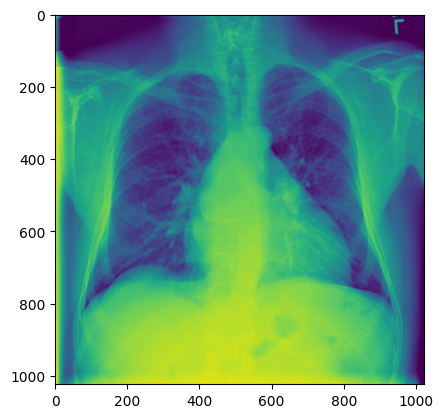

In [71]:
plt.imshow(Image.open("/data/healthy-ml/gobi1/data/ChestXray8/images/00000001_000.png"))

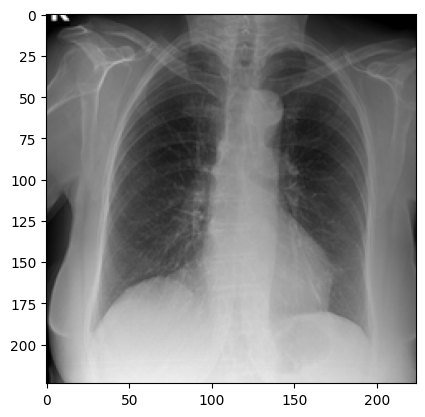

In [85]:
plt.imshow(cv2.imread("/data/healthy-ml/gobi1/data/PadChest/images-224/113855343774216031107737439268243531979_3k951l.png"), cmap='gray')